# This is a sample Jupyter Notebook

Below is an example of a code cell.
Put your cursor into the cell and press Shift+Enter to execute it and select the next one, or click 'Run Cell' button.

Press Double Shift to search everywhere for classes, files, tool windows, actions, and settings.

To learn more about Jupyter Notebooks in PyCharm, see [help](https://www.jetbrains.com/help/pycharm/ipython-notebook-support.html).
For an overview of PyCharm, go to Help -> Learn IDE features or refer to [our documentation](https://www.jetbrains.com/help/pycharm/getting-started.html).

In [1]:
!pip install torch

In [2]:
!pip install pyarrow
!pip install keras

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import math
import copy
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import numpy as np
import pyarrow.parquet as pq
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.layers import TextVectorization, Embedding, Dropout, Dense, LayerNormalization, MultiHeadAttention, Input
from tensorflow.keras import Sequential, callbacks, Model


In [2]:
class MultiHeadAttention(nn.Module):

    """
    The init constructor checks whether the provided d_model is divisible by the number of heads (num_heads).
    It sets up the necessary parameters and creates linear transformations for
    query(W_q), key(W_k) and output(W_o) projections
    """
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

    """
     The scaled_dot_product_attention function computes the scaled dot-product attention given the
     query (Q), key (K), and value (V) matrices. It uses the scaled dot product formula, applies a mask if
     provided, and computes the attention probabilities using the softmax function.
    """
    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, -1e9)
        attn_probs = torch.softmax(attn_scores, dim=-1)
        output = torch.matmul(attn_probs, V)
        return output

    """
    The split_heads and combine_heads functions handle the splitting and combining of the attention heads.
    They reshape the input tensor to allow parallel processing of different attention heads.
    """
    def split_heads(self, x):
        batch_size, seq_length, d_model = x.size()
        return x.view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1, 2)

    def combine_heads(self, x):
        batch_size, _, seq_length, d_k = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)

    """
     The forward function takes input query (Q), key (K), and value (V) tensors,
     applies linear transformations, splits them into multiple heads, performs scaled dot-product attention,
     combines the attention heads, and applies a final linear transformation.
    """
    def forward(self, Q, K, V, mask=None):
        Q = self.split_heads(self.W_q(Q))
        K = self.split_heads(self.W_k(K))
        V = self.split_heads(self.W_v(V))

        attn_output = self.scaled_dot_product_attention(Q, K, V, mask)
        output = self.W_o(self.combine_heads(attn_output))
        return output

In [3]:
class PositionWiseFeedForward(nn.Module):
    """
    PositionWiseFeedForward module. It takes d_model as the input dimension and d_ff
    as the hidden layer dimension.
    Two linear layers (fc1 and fc2) are defined with ReLU activation in between.
    """
    def __init__(self, d_model, d_ff):
        super(PositionWiseFeedForward, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()

    """
    The forward function takes an input tensor x, applies the first linear transformation (fc1),
    applies the ReLU activation, and then applies the second linear transformation (fc2).
    The output is the result of the second linear transformation.
    """
    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))

In [4]:
class PositionalEncoding(nn.Module):
    """
    The constructor (__init__) initializes the PositionalEncoding module.
    It takes d_model as the dimension of the model and max_seq_length as the maximum sequence length.
    It computes the positional encoding matrix (pe) using sine and cosine functions.
    """
    def __init__(self, d_model, max_seq_length):
        super(PositionalEncoding, self).__init__()

        pe = torch.zeros(max_seq_length, d_model)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        self.register_buffer('pe', pe.unsqueeze(0))

    """
    The forward function takes an input tensor x and adds the positional encoding to it.
    The positional encoding is truncated to match the length of the input sequence (x.size(1)).
    """
    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

In [5]:
class EncoderLayer(nn.Module):

    """
    The constructor (__init__) initializes the EncoderLayer module.
    It takes hyperparameters such as d_model (model dimension), num_heads (number of attention heads),
    d_ff (dimension of the feedforward network), and dropout (dropout rate).
    It creates instances of MultiHeadAttention, PositionWiseFeedForward, and nn.LayerNorm.
    Dropout is also defined as a module.
    """
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    """
    The forward function takes an input tensor x and a mask.
    It applies the self-attention mechanism (self.self_attn), adds the residual connection
    with layer normalization, applies the position-wise feedforward network (self.feed_forward),
    and again adds the residual connection with layer normalization.
    Dropout is applied at both the self-attention and feedforward stages.
    The mask parameter is used to mask certain positions during the self-attention step,
    typically to prevent attending to future positions in a sequence.
    """
    def forward(self, x, mask):
        attn_output = self.self_attn(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x

In [6]:
class DecoderLayer(nn.Module):
    """
    The constructor (__init__) initializes the DecoderLayer module.
    It takes hyperparameters such as d_model (model dimension), num_heads (number of attention heads),
    d_ff (dimension of the feedforward network), and dropout (dropout rate).
    It creates instances of MultiHeadAttention for both self-attention (self.self_attn) and cross-attention
    (self.cross_attn), PositionWiseFeedForward, and nn.LayerNorm. Dropout is also defined as a module.
    """
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.cross_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    """
    The forward function takes an input tensor x, the output from the encoder (enc_output),
    and masks for the source (src_mask) and target (tgt_mask). It applies the self-attention mechanism,
    adds the residual connection with layer normalization, applies the cross-attention mechanism with the
    encoder's output, adds another residual connection with layer normalization, applies the position-wise
    feedforward network, and adds a final residual connection with layer normalization.
    Dropout is applied at each stage.
    """
    def forward(self, x, enc_output, src_mask, tgt_mask):
        attn_output = self.self_attn(x, x, x, tgt_mask)
        x = self.norm1(x + self.dropout(attn_output))
        attn_output = self.cross_attn(x, enc_output, enc_output, src_mask)
        x = self.norm2(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm3(x + self.dropout(ff_output))
        return x

In [7]:
class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout):
        super(Transformer, self).__init__()
        self.encoder_embedding = nn.Embedding(src_vocab_size, d_model)
        self.decoder_embedding = nn.Embedding(tgt_vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_seq_length)

        self.encoder_layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.decoder_layers = nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])

        self.fc = nn.Linear(d_model, 2)  # 改为输出句子级别的情感分类 (0或1)
        self.dropout = nn.Dropout(dropout)

    def generate_mask(self, src, tgt):
        src_mask = (src != 0).unsqueeze(1).unsqueeze(2)
        tgt_mask = (tgt != 0).unsqueeze(1).unsqueeze(3)
        seq_length = tgt.size(1)
        nopeak_mask = (1 - torch.triu(torch.ones(1, seq_length, seq_length), diagonal=1)).bool()
        tgt_mask = tgt_mask & nopeak_mask
        return src_mask, tgt_mask

    def forward(self, src, tgt):
        src_mask, tgt_mask = self.generate_mask(src, tgt)
        src_embedded = self.dropout(self.positional_encoding(self.encoder_embedding(src)))
        tgt_embedded = self.dropout(self.positional_encoding(self.decoder_embedding(tgt)))

        enc_output = src_embedded
        for enc_layer in self.encoder_layers:
            enc_output = enc_layer(enc_output, src_mask)

        dec_output = tgt_embedded
        for dec_layer in self.decoder_layers:
            dec_output = dec_layer(dec_output, enc_output, src_mask, tgt_mask)

        # 使用解码器输出的第一个token (假设这是[CLS]位置) 来进行句子级别情感分类
        cls_token_output = dec_output[:, 0, :]  # 获取第一个token的输出
        output = self.fc(cls_token_output)
        return output

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import pyarrow.parquet as pq

# 加载数据集
def LoadDataset(file_name):
    parquet_file = pq.ParquetFile(file_name)
    data = parquet_file.read().to_pandas()
    return data

train_data = LoadDataset('/content/drive/MyDrive/Colab Notebooks/data/imdb_process/train.parquet')
validation_data = LoadDataset('/content/drive/MyDrive/Colab Notebooks/data/imdb_process/test.parquet')
test_data = LoadDataset('/content/drive/MyDrive/Colab Notebooks/data/imdb_process/unsupervised.parquet')

def preprocess_text(text, max_len=128):
    token_ids = [ord(char) for char in text[:max_len]]
    return token_ids + [0] * (max_len - len(token_ids))



In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

# 自定义损失函数
def custom_loss(outputs, labels, ignore_index=-1, negative_label_weight=0.5):
    mask = labels != ignore_index
    normal_outputs = outputs[mask]
    normal_labels = labels[mask]

    if len(normal_labels) > 0:
        normal_loss = nn.CrossEntropyLoss()(normal_outputs, normal_labels)
    else:
        normal_loss = 0

    negative_mask = labels == ignore_index
    if negative_mask.any():
        negative_outputs = outputs[negative_mask]
        negative_labels = torch.zeros_like(labels[negative_mask])
        negative_loss = nn.CrossEntropyLoss()(negative_outputs, negative_labels)
        weighted_negative_loss = negative_label_weight * negative_loss
    else:
        weighted_negative_loss = 0

    total_loss = normal_loss + weighted_negative_loss
    return total_loss

# 自定义数据集类
class TextDataset(Dataset):
    def __init__(self, data, max_len=128):
        self.texts = data['text'].values
        self.labels = data['label'].values.astype(int)
        self.max_len = max_len

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        token_ids = preprocess_text(text, self.max_len)
        return torch.tensor(token_ids), torch.tensor(label, dtype=torch.long)

train_dataset = TextDataset(train_data)
val_dataset = TextDataset(validation_data)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

def train_model(model, train_loader, val_loader, num_epochs=20, learning_rate=1e-4, patience=3, negative_label_weight=0.5):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    best_val_loss = float('inf')
    early_stop_count = 0

    for epoch in range(num_epochs):
        # 训练过程
        model.train()
        train_loss = 0
        train_preds, train_labels = [], []

        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False):
            optimizer.zero_grad()
            outputs = model(inputs, inputs)

            # 使用自定义损失函数
            loss = custom_loss(outputs.view(-1, outputs.size(-1)), labels.view(-1), ignore_index=-1, negative_label_weight=negative_label_weight)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_preds.extend(torch.argmax(outputs, dim=-1).cpu().numpy().flatten())
            train_labels.extend(labels.cpu().numpy().flatten())

        train_losses.append(train_loss / len(train_loader))

        # 计算准确率，包括标签为-1的样本
        train_accuracy = accuracy_score(train_labels, train_preds)
        train_accuracies.append(train_accuracy)

        # 验证过程
        model.eval()
        val_loss = 0
        val_preds, val_labels = [], []

        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc="Validating", leave=False):
                outputs = model(inputs, inputs)
                loss = custom_loss(outputs.view(-1, outputs.size(-1)), labels.view(-1), ignore_index=-1, negative_label_weight=negative_label_weight)
                val_loss += loss.item()

                val_preds.extend(torch.argmax(outputs, dim=-1).cpu().numpy().flatten())
                val_labels.extend(labels.cpu().numpy().flatten())

        val_losses.append(val_loss / len(val_loader))

        # 计算验证集的准确率，包括标签为-1的样本
        val_accuracy = accuracy_score(val_labels, val_preds)
        val_accuracies.append(val_accuracy)

        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracy:.4f}, '
              f'Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracy:.4f}')

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stop_count = 0
        else:
            early_stop_count += 1
            if early_stop_count >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

        scheduler.step()

    return train_losses, val_losses, train_accuracies, val_accuracies



Epoch 1/20, Train Loss: 0.7069, Train Acc: 0.5008, Val Loss: 0.6937, Val Acc: 0.5000


Epoch 2/20, Train Loss: 0.6963, Train Acc: 0.5066, Val Loss: 0.6956, Val Acc: 0.5049


Epoch 3/20, Train Loss: 0.6943, Train Acc: 0.5100, Val Loss: 0.6959, Val Acc: 0.5000


Epoch 4/20, Train Loss: 0.6947, Train Acc: 0.5084, Val Loss: 0.6932, Val Acc: 0.5112


Epoch 5/20, Train Loss: 0.6934, Train Acc: 0.5170, Val Loss: 0.6927, Val Acc: 0.5154


Epoch 6/20, Train Loss: 0.6923, Train Acc: 0.5228, Val Loss: 0.6973, Val Acc: 0.5000


Epoch 7/20, Train Loss: 0.6927, Train Acc: 0.5147, Val Loss: 0.6928, Val Acc: 0.5105


Epoch 8/20, Train Loss: 0.6925, Train Acc: 0.5179, Val Loss: 0.6930, Val Acc: 0.5045
Early stopping at epoch 8


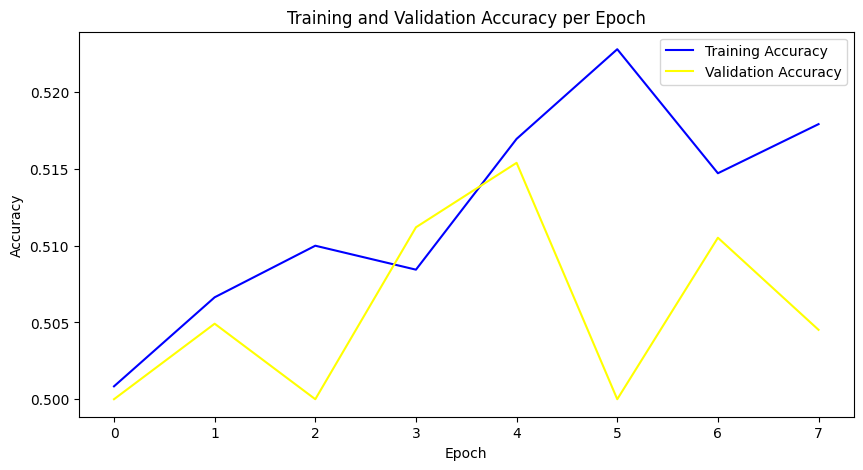

In [11]:
model = Transformer(src_vocab_size=1000, tgt_vocab_size=1000, d_model=512, num_heads=8,
                    num_layers=6, d_ff=2048, max_seq_length=128, dropout=0.1)

train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, train_loader, val_loader, num_epochs=20)

plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy', color='blue')
plt.plot(val_accuracies, label='Validation Accuracy', color='yellow')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy per Epoch')
plt.savefig('accuracy_plot.png')
plt.show()



np.savez('training_results.npz', train_losses=train_losses, val_losses=val_losses,
         train_accuracies=train_accuracies, val_accuracies=val_accuracies)